## **RECEIPT RADAR**

Develop a fine-tuned language model (LLM) capable of converting raw OCR text from receipts and invoices into structured JSON format, extracting key information.

### PLANNING:

1. Load dataset from HuggingFace
2. Use Paddle OCR for ocr tasks
3. Finetune of Mistral 7b model


[GET IMAGE] --> [OCR FRAMEWORK] --> [GET TEXT] --> [CREATE PROMPT DATASET] --> [FINETUNE GEMINI] --> [ACCESS FINETUNED MODEL]



**Instructions from organizers:**

1. **Select a suitable language model for fine-tuning** (e.g., a smaller LLM).
2. **Dataset generation:**

    a. Gather raw OCR text from dummy receipts and invoices available online.

    b. Use an LLM service like GPT-3.5 or Gemini to structure the raw OCR text into JSON objects. You can write a script to automate this process.

    c. You can use datasets like CORD or any other dataset you find useful. You may check out Hugging Face for datasets or simply Google for datasets. Select a dataset that suits your needs. Also, consider shrinking down the size of your dataset based on the Colab RAM availability if memory limit exceeds.
    
    d. Divide the dataset into train, test, and validation.
3. **Ensure that the fine-tuned model** has raw OCR text as input and structured JSON as output.
4. **Provide results defining accuracy, precision, and recall** for the fine-tuned model.
5. **Note:** Avoid image-to-text models like Vision Transformers (solutions using image-to-text will not be considered).

Ensure the model can identify and extract important keys from receipts and invoices effectively.

# Dataset
https://huggingface.co/datasets/mychen76/invoices-and-receipts_ocr_v1

In [1]:
! pip install datasets -q
import re
import json
import numpy as np
import pandas as pd
from ast import literal_eval
from tqdm.notebook import tqdm
from datasets import load_dataset

import warnings, logging
warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

In [2]:
dataset_id="mychen76/invoices-and-receipts_ocr_v1"
dataset = load_dataset(dataset_id)

Generating train split:   0%|          | 0/2043 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/125 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/70 [00:00<?, ? examples/s]

In [3]:
train = dataset['train']
test = dataset['test']
val = dataset['valid']

In [4]:
train = train.select(range(100))

In [5]:
! pip install pytesseract

In [6]:
import pytesseract
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt



def tess_ocr(input_image):
    text = ''
    rgb_image = input_image.convert('RGB')
    receipt_image_array = np.array(rgb_image)
    text = pytesseract.image_to_string(rgb_image)

    return text

n = len(train)

txts = []

for i in tqdm(range(n)):
    input_image = train[i]['image']
    texts = tess_ocr(input_image)
    txts.append(texts)

  0%|          | 0/100 [00:00<?, ?it/s]

# Generating Training data


In [8]:
df = train.to_pandas()
df = df.head(100)

In [10]:
import google.generativeai as genai
from google.colab import userdata

genai.configure(api_key=userdata.get('GEMINI_API_KEY'))

safety_settings = [
  {
    "category": "HARM_CATEGORY_HARASSMENT",
    "threshold": "BLOCK_ONLY_HIGH"
  },
  {
    "category": "HARM_CATEGORY_HATE_SPEECH",
    "threshold": "BLOCK_ONLY_HIGH"
  },
  {
    "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
    "threshold": "BLOCK_NONE"
  },
  {
    "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
    "threshold": "BLOCK_ONLY_HIGH"
  },
]

# Set up the model
generation_config = {
  "temperature": 0.95,
  "top_p": 0.95
}

In [11]:
def correct_text(prompt):
    model = genai.GenerativeModel(model_name='gemini-pro',
                              generation_config=generation_config,
                              safety_settings=safety_settings)
    response = model.generate_content(prompt)
    return response.text

In [12]:
df.head()

,image,id,parsed_data,raw_data
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0,"{""xml"": """", ""json"": ""{'header': {'invoice_no':...","{""ocr_words"": ""['Invoice no: 40378170', 'Date ..."
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,1,"{""xml"": """", ""json"": ""{'header': {'invoice_no':...","{""ocr_words"": ""['Invoice no: 61356291', 'Date ..."
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,10,"{""xml"": """", ""json"": ""{'header': {'invoice_no':...","{""ocr_words"": ""['Invoice no: 39280409', 'Date ..."
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,100,"{""xml"": """", ""json"": ""{'header': {'invoice_no':...","{""ocr_words"": ""['Invoice no: 27301261', 'Date ..."
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,101,"{""xml"": """", ""json"": ""{'header': {'invoice_no':...","{""ocr_words"": ""['Invoice no: 10823698', 'Date ..."


In [13]:
def to_json_text(text):
    data_dict = json.loads(text)
    return data_dict['json'].replace("'", '"')

In [14]:
df['json_text'] = df['parsed_data'].apply(to_json_text)

In [16]:
for i, row in tqdm(df.iterrows(), total = len(df)):
    df.at[i, 'prompt'] = correct_text(f'''fix the fomatting of the string below to be eligible for json.loads().\n {row['json_text']} \n return the reformatted text only''')

  0%|          | 0/100 [00:00<?, ?it/s]

In [17]:
df.head()

,image,id,parsed_data,raw_data,json_text,prompt
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0,"{""xml"": """", ""json"": ""{'header': {'invoice_no':...","{""ocr_words"": ""['Invoice no: 40378170', 'Date ...","{""header"": {""invoice_no"": ""40378170"", ""invoice...","{""header"": {""invoice_no"": ""40378170"", ""invoice..."
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,1,"{""xml"": """", ""json"": ""{'header': {'invoice_no':...","{""ocr_words"": ""['Invoice no: 61356291', 'Date ...","{""header"": {""invoice_no"": ""61356291"", ""invoice...","{""header"": {""invoice_no"": ""61356291"", ""invoice..."
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,10,"{""xml"": """", ""json"": ""{'header': {'invoice_no':...","{""ocr_words"": ""['Invoice no: 39280409', 'Date ...","{""header"": {""invoice_no"": ""39280409"", ""invoice...","{""header"": {""invoice_no"": ""39280409"", ""invoice..."
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,100,"{""xml"": """", ""json"": ""{'header': {'invoice_no':...","{""ocr_words"": ""['Invoice no: 27301261', 'Date ...","{""header"": {""invoice_no"": ""27301261"", ""invoice...","{\n ""header"": {\n ""invoice_no"": ""27301261""..."
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,101,"{""xml"": """", ""json"": ""{'header': {'invoice_no':...","{""ocr_words"": ""['Invoice no: 10823698', 'Date ...","{""header"": {""invoice_no"": ""10823698"", ""invoice...","{""header"": {""invoice_no"": ""10823698"", ""invoice..."


In [18]:
for i, row in df.iterrows():
    try:
        row['output'] = json.loads(row['prompt'])
    except Exception as e:
        print(f'The string has issues at index {i}')
        row['output'] = None

The string has issues at index 3
The string has issues at index 26
The string has issues at index 49
The string has issues at index 71
The string has issues at index 79
The string has issues at index 98


In [19]:
df = df.dropna()
df.head()

,image,id,parsed_data,raw_data,json_text,prompt
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0,"{""xml"": """", ""json"": ""{'header': {'invoice_no':...","{""ocr_words"": ""['Invoice no: 40378170', 'Date ...","{""header"": {""invoice_no"": ""40378170"", ""invoice...","{""header"": {""invoice_no"": ""40378170"", ""invoice..."
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,1,"{""xml"": """", ""json"": ""{'header': {'invoice_no':...","{""ocr_words"": ""['Invoice no: 61356291', 'Date ...","{""header"": {""invoice_no"": ""61356291"", ""invoice...","{""header"": {""invoice_no"": ""61356291"", ""invoice..."
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,10,"{""xml"": """", ""json"": ""{'header': {'invoice_no':...","{""ocr_words"": ""['Invoice no: 39280409', 'Date ...","{""header"": {""invoice_no"": ""39280409"", ""invoice...","{""header"": {""invoice_no"": ""39280409"", ""invoice..."
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,100,"{""xml"": """", ""json"": ""{'header': {'invoice_no':...","{""ocr_words"": ""['Invoice no: 27301261', 'Date ...","{""header"": {""invoice_no"": ""27301261"", ""invoice...","{\n ""header"": {\n ""invoice_no"": ""27301261""..."
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,101,"{""xml"": """", ""json"": ""{'header': {'invoice_no':...","{""ocr_words"": ""['Invoice no: 10823698', 'Date ...","{""header"": {""invoice_no"": ""10823698"", ""invoice...","{""header"": {""invoice_no"": ""10823698"", ""invoice..."


In [20]:
df1 = df.copy()
del df

In [21]:
df2 = pd.DataFrame(txts, columns=['ocr'])

In [23]:
df = df2.merge(df1['prompt'], left_index=True, right_index=True)
df.to_csv('df.csv', index=None)

In [24]:
df.head()

,ocr,prompt
0,Invoice no: 40378170\n\nDate of issue:\n\nSell...,"{""header"": {""invoice_no"": ""40378170"", ""invoice..."
1,Invoice no: 61356291\n\nDate of issue:\n\nSell...,"{""header"": {""invoice_no"": ""61356291"", ""invoice..."
2,Invoice no: 39280409\n\nDate of issue:\n\nSell...,"{""header"": {""invoice_no"": ""39280409"", ""invoice..."
3,Invoice no: 27301261\n\nDate of issue:\n\nSell...,"{\n ""header"": {\n ""invoice_no"": ""27301261""..."
4,Invoice no: 10823698\n\nDate of issue: 09/26/2...,"{""header"": {""invoice_no"": ""10823698"", ""invoice..."


# Next Steps:

Data is tuned at https://aistudio.google.com/app/
under application `GeminiDN1-AnuSangha`


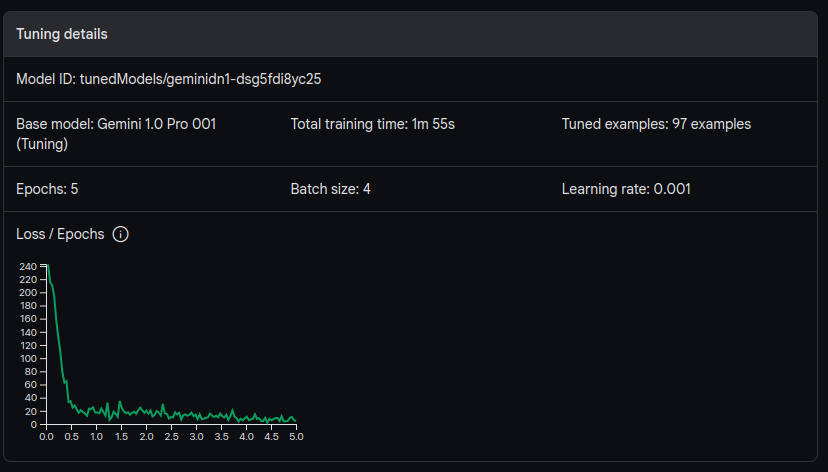

In [3]:
!gcloud auth application-default login --no-browser --client-id-file client_json.json --scopes='https://www.googleapis.com/auth/cloud-platform,https://www.googleapis.com/auth/generative-language.tuning'

You are authorizing client libraries without access to a web browser. Please run the following command on a machine with a web browser and copy its output back here. Make sure the installed gcloud version is 372.0.0 or newer.



gcloud auth application-default login --remote-bootstrap="https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=307326879786-t6vqia93fr4ndgjvegafi9eisghbtefq.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fgenerative-language.tuning&state=0jkDil7NM6EGPfPwSheO88MevsBihk&access_type=offline&code_challenge=QvG9c_CiojxqLZmPWk3ceBnq1qkAaaDuqdsv37gFsrM&code_challenge_method=S256&token_usage=remote"





Enter the output of the above command: https://localhost:8085/?state=0jkDil7NM6EGPfPwSheO88MevsBihk&code=4/0ATx3LY7kC_O6haDrnsb4hr-x27OOOC-F79ltVn9wbkdEkXL8GwllJTf6J0UjH3Yt6XLDVw&scope=https://www.googleapis.com/auth/cloud-platform%20https://www.googleapis.com/auth/gen

In [4]:
import google.generativeai as genai

model_name = 'tunedModels/geminidn1-dsg5fdi8yc25'  

model = genai.GenerativeModel(model_name=model_name)
model

genai.GenerativeModel(
    model_name='tunedModels/geminidn1-dsg5fdi8yc25',
    generation_config={},
    safety_settings={},
    tools=None,
    system_instruction=None,
)

In [5]:
input = '''Invoice no: 40378170\n\nDate of issue:\n\nSeller:\n\nPatel, Thompson and Montgomery\n356 Kyle Vista\nNew James, MA 46228\n\nTax Id: 958-74-3511\nIBAN: GB77WRBQ31965128414006\n\nITEMS\nNo. Description Qty\n1. Leed's Wine Companion Bottle 1,00\n\nCorkscrew Opener Gift Box Set\nwith Foil Cutter\n\nSUMMARY\n\nVAT [%]\n10%\n\nTotal\n\n10/15/2012\n\nClient:\n\nJackson, Odonnell and Jackson\n267 John Track Suite 841\nJenniferville, PA 98601\n\nTax Id: 998-87-7723\n\nUM Net price Net worth VAT [%]\neach 7,50 7,50 10%\nNet worth VAT\n7,50 0,75\n$ 7,50 $ 0,75\n\nGross\nworth\n\n8,25\n\nGross worth\n8,25\n\n$ 8,25\n\x0c'''
response = model.generate_content(input)

In [9]:
print(response.text)

{'client': None, 'client_tax_id': None, 'header': {'client': 'Jackson, Odonnell and Jackson 267 John Track Suite 841 Jenniferville, PA 98601', 'client_tax_id': '998-87-7723', 'iban': 'GB77WRBQ31965128414006', 'invoice_date': '10/15/2012', 'invoice_no': '40378170', 'seller': 'Patel, Thompson and Montgomery 356 Kyle Vista New James, MA 46228', 'seller_tax_id': '958-74-3511'}, 'iban': None, 'invoice_date': None, 'invoice_no': None, 'item_desc': None, 'item_gross_worth': None, 'item_net_price': None, 'item_net_worth': None, 'item_qty': None, 'item_vat': None, 'items': array([{'iban': None, 'item_desc': "Leed's Wine Companion Bottle Corkscrew Opener Gift Box Set with Foil Cutter", 'item_gross_worth': '8,25', 'item_net_price': '7,50', 'item_net_worth': '7,50', 'item_qty': '1,00', 'item_vat': '10%', 'total_net_worth': None}],

      dtype=object), 'seller': None, 'seller_tax_id': None, 'summary': {'total_gross_worth': '8,25', 'total_net_worth': '7,50', 'total_vat': '0,75'}, 'total_gross_worth